<a href="https://colab.research.google.com/github/shubhamcweb/ASLDictionarySearch/blob/main/ASLDictionarySearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/00_patrec/projects/sign_search

/content/drive/.shortcut-targets-by-id/1uZKk00M-s8oTcapG92D_oyNt2zVOAI_Z/00_patrec/projects/sign_search


In [3]:
import numpy as np
import scipy.io.matlab as mat
import matplotlib.pyplot as plt

#data structure that contains some basic information about every signs
class sign_info:
    label = None    # class label, int
    signer = None   # ID of the person who produced the sign, int
    gloss = None    # string, information about the meaning of the sign
    nhands = None   # 1 for one-handed signs, 2 for 2-handed signs

    # the directory and filename are strings that specify the directory
    # and filename where the videos can be viewed on Google Drive.
    # These directories can be found at:
    # https://drive.google.com/drive/folders/1D-YYjDeByNqYoY1VuROacTzfJWWopWPn?usp=sharing
    directory = None
    filename = None

    start = None    # start frame of the sign in the video
    end = None      # end frame of the sign in the video

    dom = None      # 2D numpy array of ints.
                    # dom[i] is the location of the bounding box
                    # of the dominant hand in frame i, expressed by
                    # [left_col, top_row, width, height]
    ndom = None     # similar format as dom, but for non-dominant hand
                    # It is left empty if nhands = 1
    face = None     # numpy array of 4 numbers: [left_col, top_row, width, height]
                    # It describes the position of the face (assumed ) to
                    # not move through the duration of the sign.

#(data, keys) = load_annotations(filename)
#loads informations about the set of signs stored in the specific filename
#this information doesn't include hand or face positions
def load_annotations(filename):
    data_raw = mat.loadmat(filename)
    data = data_raw["data"][0,0]
    keys = data.dtype.fields.keys()

    return (data, list(keys))

#data = load_handface(filename)
#complement to load_annotations; loads info about hand and face positions in a set of signs
def load_handface(filename):
    data_raw = mat.loadmat(filename)
    data = data_raw["handface"]

    return data

# info = sign_data(index, annotations, handface)
# Returns information about the sign with the specific index.
def sign_data(index, annotations, handface):
    info = sign_info()
    info.label = annotations["id"][index,0]
    info.gloss = annotations["lexicon"][index,0][0]

    sign_type = annotations["type"][index,0]
    info.nhands = 1 if (sign_type == 1) else 2

 #   info.directory = annotations["directory"][index,0][0]
 #   info.filename = annotations["filename"][index,0][0]
    info.start = annotations["startframe"][index,0]
    info.end = annotations["endframe"][index,0]

    info.dom = handface[index,0]
    info.ndom = handface[index,1]
    info.face = handface[index,2]

    return info


# box is a numpy array containing left, top, width, height.
#draws the box to indicate the position of the face (but could be used for any box)
def draw_box(box):
    box = box.astype(float)
    left = box[0, 0]
    top = box[0, 1]
    width = box[0, 2]
    height = box[0, 3]

    right = left + width - 1
    bottom = top - height + 1
    xs = [left, right, right, left, left]
    ys = [top, top, bottom, bottom, top]
    plt.plot(xs, ys, "-or")


# positions is either class_info.dom or class_info.ndom
# position is a 2D array, where each row corresponds to a frame of the sign video.
# column 0 is the left-most position of the hand, and column 1 is top-most position, 2 is width & 3 is height.
# we return a numpy 2D array, with same rows as positions,
# and two columns, containing the center of the bounding box at each frame.
def get_centers(positions):
    positions = positions.astype(float)
    lefts = positions[:,0]
    tops = positions[:,1]
    widths = positions[:,2]
    heights = positions[:,3]

    rights = lefts + widths - 1
    bottoms = tops + heights - 1

    (frames, _) = positions.shape
    result = np.zeros((frames, 2))
    result[:,0] = (lefts + rights) / 2
    result[:,1] = (tops + bottoms) / 2

    return result

# creates a figure showing hand and face positions for the sign and then prints some other information
def show_sign_info(info):
    centers = get_centers(info.dom)

    plt.figure()

    plt.xlim([0, 640])
    xticks = range(0, 641, 80)
    plt.xticks(xticks)

    plt.ylim([480, 0])
    yticks = range(0, 481, 80)
    plt.yticks(yticks)

    (frames, _) = info.dom.shape
    half = round(frames/2)

    plt.plot(centers[0,0], centers[0,1], "xr")
    plt.plot(centers[0:half,0], centers[0:half,1], "-r")
    plt.plot(centers[half:frames,0], centers[half:frames,1], "-b")
    if (info.nhands == 2):
        centers = get_centers(info.ndom)
        plt.plot(centers[0,0], centers[0,1], "xg")
        plt.plot(centers[0:half,0], centers[0:half,1], "-g")
        plt.plot(centers[half:frames,0], centers[half:frames,1], "-k")

    draw_box(info.face)
    print("label = %d, gloss = %s, %d frames" %
          (info.label, info.gloss, frames))

    gdrive_link = "https://drive.google.com/drive/folders/1D-YYjDeByNqYoY1VuROacTzfJWWopWPn?usp=sharing"
    print("Videos are stored at link %s" % (gdrive_link))

  #  print("The video for this sign is at %s/%s, frames %d-%d" %
  #        (info.directory, info.filename, info.start, info.end))

    print() # prints empty line

label = 47, gloss = address, 43 frames
Videos are stored at link https://drive.google.com/drive/folders/1D-YYjDeByNqYoY1VuROacTzfJWWopWPn?usp=sharing



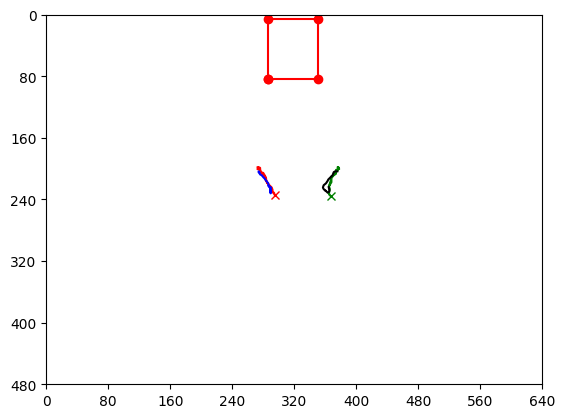

In [4]:
# load the first part of the data-set
directory = "sga2010/"
ann_filename = directory + "annotation_lb1113.mat"
hf_filename = directory + "handface_manual_lb1113.mat"

(lb_ann, ann_keys) = load_annotations(ann_filename)
lb_hf = load_handface(hf_filename)

info = sign_data(35, lb_ann, lb_hf)
show_sign_info(info)

label = 1587, gloss = mother, 32 frames
Videos are stored at link https://drive.google.com/drive/folders/1D-YYjDeByNqYoY1VuROacTzfJWWopWPn?usp=sharing



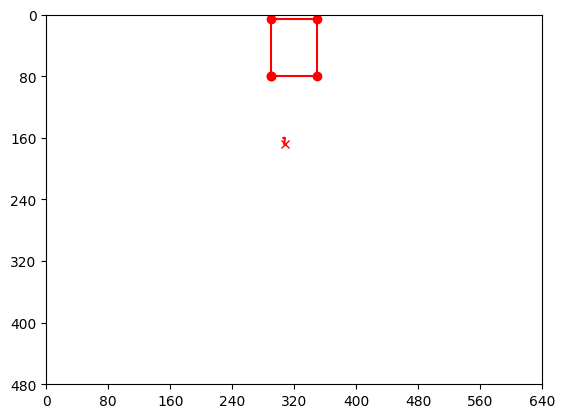

In [5]:
info = sign_data(1082, lb_ann, lb_hf)
show_sign_info(info)

label = 885, gloss = father-fr, 27 frames
Videos are stored at link https://drive.google.com/drive/folders/1D-YYjDeByNqYoY1VuROacTzfJWWopWPn?usp=sharing



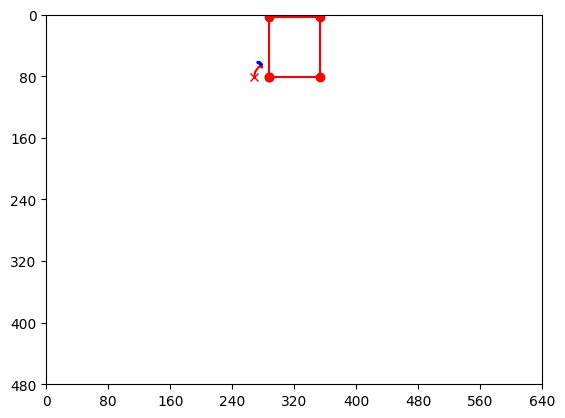

In [6]:
info = sign_data(618, lb_ann, lb_hf)
show_sign_info(info)

label = 47, gloss = address, 23 frames
Videos are stored at link https://drive.google.com/drive/folders/1D-YYjDeByNqYoY1VuROacTzfJWWopWPn?usp=sharing



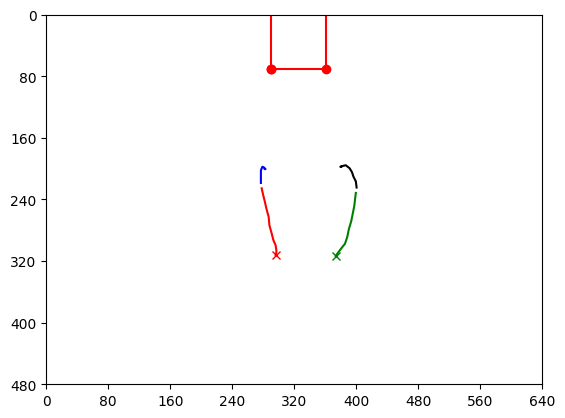

In [7]:
# load the second part of the data-set
directory = "sga2010/"
ann_filename = directory + "annotation_tb1113.mat"
hf_filename = directory + "handface_manual_tb1113.mat"

(tb_ann, ann_keys) = load_annotations(ann_filename)
tb_hf = load_handface(hf_filename)

info = sign_data(35, tb_ann, tb_hf)
show_sign_info(info)

label = 47, gloss = address, 23 frames
Videos are stored at link https://drive.google.com/drive/folders/1D-YYjDeByNqYoY1VuROacTzfJWWopWPn?usp=sharing

label = 47, gloss = address, 23 frames
Videos are stored at link https://drive.google.com/drive/folders/1D-YYjDeByNqYoY1VuROacTzfJWWopWPn?usp=sharing



array([[296. , 312.5],
       [297. , 308.5],
       [297. , 306.5],
       [296. , 299.5],
       [293. , 292.5],
       [291. , 284.5],
       [288. , 273.5],
       [287. , 262.5],
       [284. , 251.5],
       [282. , 242.5],
       [280. , 234.5],
       [278. , 225.5],
       [277. , 218.5],
       [277. , 212.5],
       [277. , 207.5],
       [277. , 202.5],
       [278. , 199.5],
       [279. , 197.5],
       [281. , 198.5],
       [283. , 200.5],
       [283. , 200.5],
       [282. , 200.5],
       [282. , 200.5]])

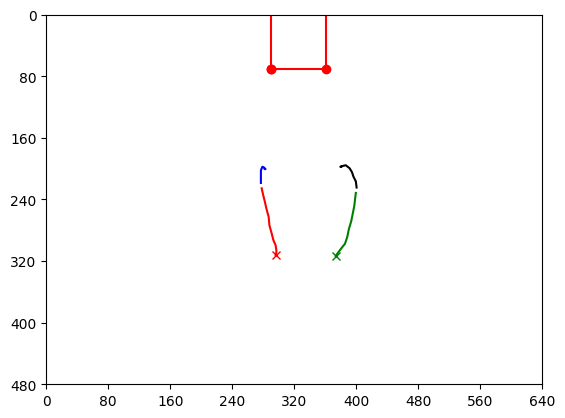

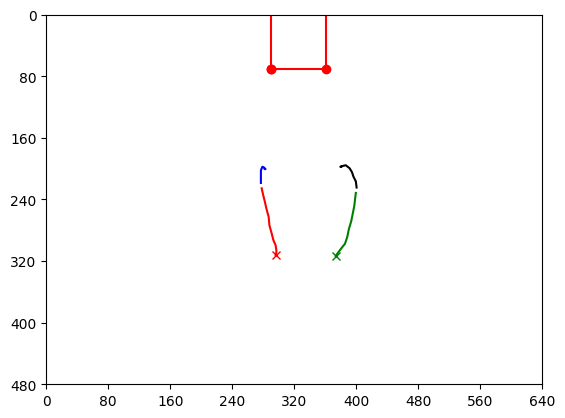

In [8]:
tinfo = sign_data(35, tb_ann, tb_hf)
show_sign_info(info)

linfo = sign_data(35, lb_ann, lb_hf)
show_sign_info(info)

get_centers(info.dom)

In [9]:
print(tinfo.dom.shape)
print(linfo.dom.shape)

(23, 4)
(43, 4)


In [10]:
# this function takes an array describing the position of the hand at each frame of the sign....
# and produces an array where the number of rows is fixed.
# points should be a rows x 2 array, every row is a 2D point
def interpolate(points, new_rows):
    (rows, cols) = points.shape
    result = np.zeros((new_rows, cols))
    steps = np.array(range(0, new_rows)).astype(float)
    steps = (steps / new_rows) * rows
    original_steps = np.array(range(0,rows)).astype(float)

    for c in range(0, cols):
        sequence = points[:,c]
        result[:,c] = np.interp(steps, original_steps, sequence)
    return result


# function used for debugging the visualization.
# it draws a 2D array of hand positions for a sign.
def draw_points(points):
    plt.figure()


    """
    plt.xlim([0, 640])
    xticks = range(0, 641, 80)
    plt.xticks(xticks)

    plt.ylim([480, 0])
    yticks = range(0, 481, 80)
    plt.yticks(yticks)
    """
    y_min = points.min(0)[1]
    y_max = points.max(0)[1]
    plt.ylim([y_max+5, y_min-5])

    (frames, _) = points.shape
    half = round(frames/2)

    plt.plot(points[0,0], points[0,1], "xr")
    plt.plot(points[0:half,0], points[0:half,1], ".-r")
    plt.plot(points[half,0], points[half,1], "xb")
    plt.plot(points[half:frames,0], points[half:frames,1], ".-b")


# just a debugging function to visualize and understand the interpolate function
def test_interp(info, new_rows):
    centers = get_centers(info.dom)
    result = interpolate(centers, new_rows)

    draw_points(centers)
    draw_points(result)

In [11]:
linfo

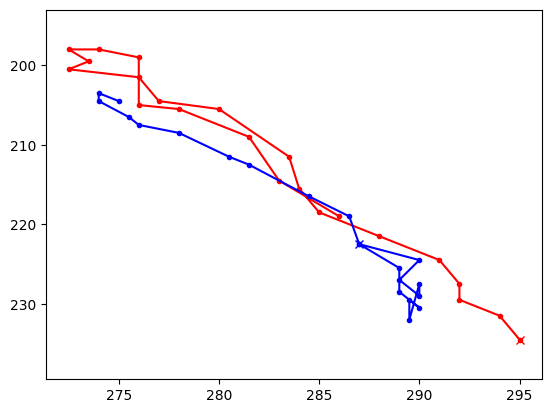

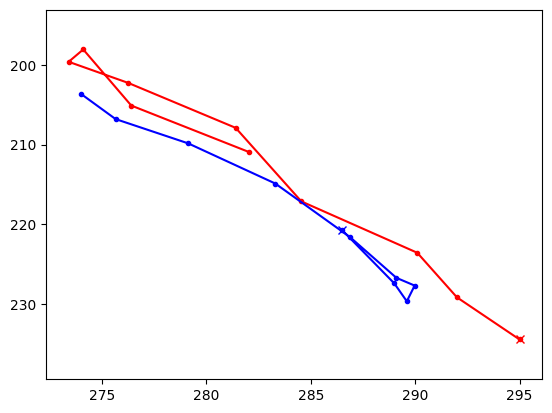

In [12]:
test_interp(linfo, 20)

[[285.  158.5]
 [285.9 156.7]
 [286.8 155.7]
 [288.4 155.5]
 [290.2 154.9]
 [291.5 154. ]
 [292.4 153.1]
 [293.9 152.8]
 [296.4 153.7]
 [298.1 154.5]
 [299.  154.5]
 [299.  153.6]
 [299.8 151.9]
 [300.7 152.9]
 [301.  155.3]
 [301.  158.5]
 [301.  162.1]
 [301.  165.1]
 [301.  166.7]
 [301.  167.5]] (20, 2)


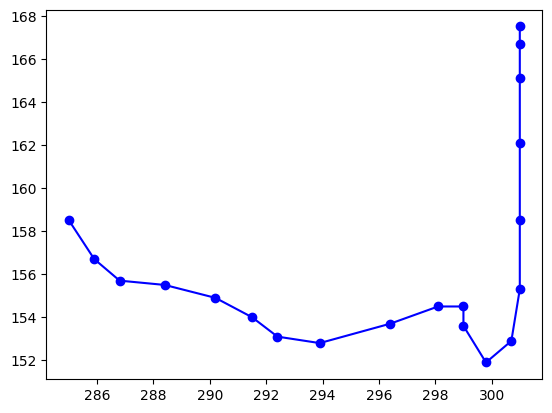

In [13]:
# takes information about a sign stored in info and converts it to a fixed sized matrix containing positions of the hand
# for as many moments in time as specified by the fixed_size argument
def standardize(info, fixed_size):
  centers = get_centers(info.dom)
  resize = interpolate(centers, fixed_size)
  return resize

info = sign_data(100, lb_ann, lb_hf)
resize = standardize(info, 20)

print(resize, resize.shape)
plt.plot(resize[:,0], resize[:,1], 'b-o')

In [14]:
# creates a 3D array of either training or test inputs by standardizing the information stored in annotations about the set of signs
def make_set(annotation, handface, fixed_size):
  number = annotation["id"].shape[0]
  inputs = np.zeros((number, fixed_size, 2))
  labels = np.zeros(number)

  for i in range(0, number):
    info = sign_data(i, annotation, handface)
    matrix = standardize(info, fixed_size)
    inputs[i] = matrix
    labels[i] = info.label

  return (inputs, labels)

fixed_size = 20

(training_inputs, training_labels) = make_set (lb_ann, lb_hf, fixed_size)
print(training_inputs.shape)

(test_inputs, test_labels) = make_set(tb_ann, tb_hf, fixed_size)
print(test_inputs.shape)

(1113, 20, 2)
(1113, 20, 2)


In [15]:
# classifies the test input, which corresponds to a single sign, by finding its nearest neighbour in the training set
def nn_classify(test_inputs, training_inputs, training_labels):
  number = training_inputs.shape[0]
  distances = np.zeros(number)

  for i in range(0, number):
    example = training_inputs[i]
    diff = test_inputs - example
    abs_diff = np.abs(diff)
    distances[i] = abs_diff.sum()

  nn_index = distances.argmin()

  return (training_labels[nn_index], nn_index)


# evaluates the accuracy of nearest neighbour evaluation  based on the results of the entire test set
def nn_evaluate(test_inputs, test_labels, training_inputs, training_labels):
  correct = 0
  number = training_inputs.shape[0]
  for index in range(0,number):
    label = test_labels[index]

    (result, nn_index) = nn_classify(test_inputs[index], training_inputs, training_labels)
    #print("Label = %d, result = %d"%(label, result))

    training_info = sign_data(nn_index, tb_ann, tb_hf)
    #print("Result label =", training_info.gloss)

    test_info = sign_data(index, lb_ann, lb_hf)
    #print("Correct label =", test_info.gloss)

    if(label==result):
      correct = correct + 1

  accuracy = correct*100/number

  return accuracy

accuracy = nn_evaluate(test_inputs, test_labels, training_inputs, training_labels)
print("Accuracy =", accuracy)

Accuracy = 5.480682839173405


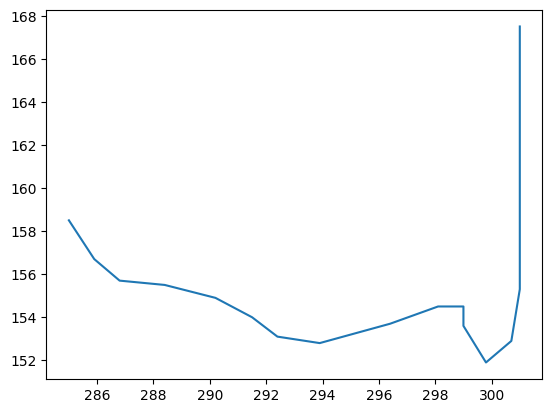

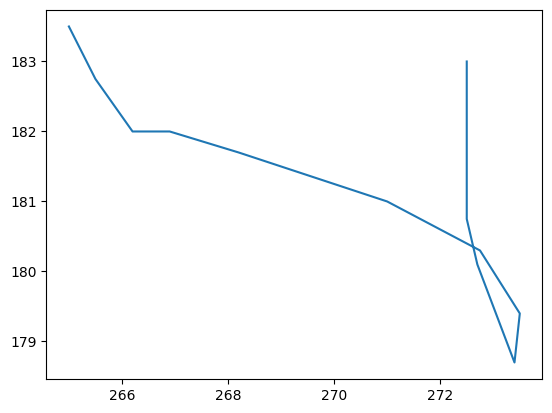

In [16]:
l35 = training_inputs[100]
t35 = test_inputs[100]

plt.figure()
plt.plot(l35[:,0], l35[:,1])

plt.figure()
plt.plot(t35[:,0], t35[:,1])

[[-0.33324887  0.27223147]
 [-0.32480031  0.25533435]
 [-0.31635175  0.24594706]
 [-0.30133208  0.2440696 ]
 [-0.28443495  0.23843722]
 [-0.27223147  0.22998866]
 [-0.26378291  0.2215401 ]
 [-0.24970197  0.21872391]
 [-0.22623374  0.22717247]
 [-0.21027535  0.2346823 ]
 [-0.20182678  0.2346823 ]
 [-0.20182678  0.22623374]
 [-0.19431695  0.21027535]
 [-0.18586839  0.21966264]
 [-0.1830522   0.24219214]
 [-0.1830522   0.27223147]
 [-0.1830522   0.30602573]
 [-0.1830522   0.3341876 ]
 [-0.1830522   0.34920727]
 [-0.1830522   0.3567171 ]] (20, 2)


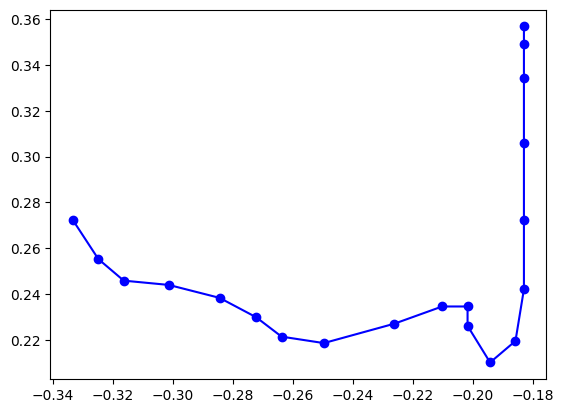

In [18]:
# improved approach for standardizing representation of a sign
# here, hand positions are normalized based on the location and size of the face
def standardize2(info, fixed_size):
  centers = get_centers(info.dom)
  resize = interpolate(centers, fixed_size)

  face = info.face.astype(float)
  left = face[0,0]
  top = face[0,1]
  width = face[0,2]
  height = face[0,3]

  right = left + width - 1
  bottom = top + height - 1
  center_x = (left + right)/2
  center_y = (top + bottom)/2

  resize[:,0] = resize[:,0] - center_x
  resize[:,1] = resize[:,1] - center_y

  diag = np.sqrt(width**2 + height**2)
  resize = resize/diag

  return resize

info = sign_data(100, lb_ann, lb_hf)
resize = standardize2(info, 20)

print(resize, resize.shape)
plt.plot(resize[:,0], resize[:,1], 'b-o')

In [19]:
# similar to make_set, uses standardize2 instead of standardize
def make_set2(annotation, handface, fixed_size):
  number = annotation["id"].shape[0]
  inputs = np.zeros((number, fixed_size, 2))
  labels = np.zeros(number)

  for i in range(0, number):
    info = sign_data(i, annotation, handface)
    matrix = standardize2(info, fixed_size)
    inputs[i] = matrix
    labels[i] = info.label

  return (inputs, labels)

fixed_size = 20

(training_inputs, training_labels) = make_set2(lb_ann, lb_hf, fixed_size)
print(training_inputs.shape)

(test_inputs, test_labels) = make_set2(tb_ann, tb_hf, fixed_size)
print(test_inputs.shape)

(1113, 20, 2)
(1113, 20, 2)


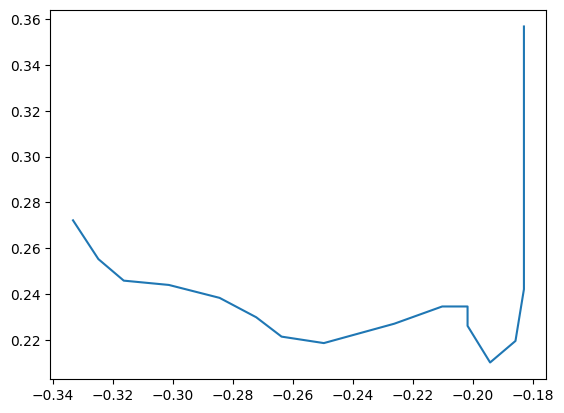

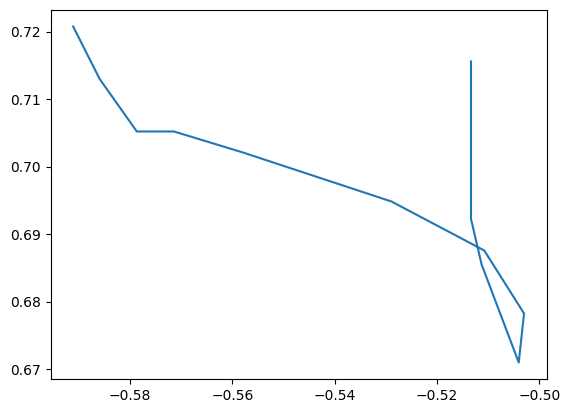

In [20]:
l35 = training_inputs[100]
t35 = test_inputs[100]

plt.figure()
plt.plot(l35[:,0], l35[:,1])

plt.figure()
plt.plot(t35[:,0], t35[:,1])

In [22]:
accuracy = nn_evaluate(test_inputs, test_labels, training_inputs, training_labels)
print("Accuracy =", accuracy)

Accuracy = 7.0979335130278525


In [23]:
# similar to nn_classify, but here the data is produced using standardize2
def nn_classify2(test_inputs, nhands, training_inputs, training_labels, training_annotations):
  number = training_inputs.shape[0]
  distances = np.zeros(number)

  training_nhands = training_annotations["type"]
  training_nhands[training_nhands == 3] = 2

  for i in range(0, number):
    if (nhands != training_nhands[i]):
      distances[i] = np.inf
    else:
      example = training_inputs[i]
      diff = test_inputs - example
      abs_diff = np.abs(diff)
      distances[i] = abs_diff.sum()

  nn_index = distances.argmin()

  return (training_labels[nn_index], nn_index)


# evaluates the accuracy when datasets are standardized using standardize2
def nn_evaluate2(test_inputs, test_annotations, test_labels, training_inputs, training_labels, training_annotations):
  test_nhands = test_annotations["type"]
  test_nhands[test_nhands == 3] = 2

  correct = 0
  number = training_inputs.shape[0]

  for index in range(0,number):
    label = test_labels[index]
    nhands = test_nhands[index]

    (result, nn_index) = nn_classify2(test_inputs[index], nhands, training_inputs, training_labels, training_annotations)
    #print("Label = %d, result = %d"%(label, result))

    training_info = sign_data(nn_index, tb_ann, tb_hf)
    #print("Result label =", training_info.gloss)

    test_info = sign_data(index, lb_ann, lb_hf)
    #print("Correct label =", test_info.gloss)

    if(label==result):
      correct = correct + 1

  accuracy = correct*100/number

  return accuracy

accuracy = nn_evaluate2(test_inputs, tb_ann, test_labels, training_inputs, training_labels, lb_ann)
print("Accuracy =", accuracy)

Accuracy = 9.883198562443846


In [24]:
# computes a matrix, which at position [i,j] stores the distance of test input i to training input j
def compute_dist(test_inputs, test_annotations, test_labels, training_inputs, training_labels, training_annotations):
  test_number = test_inputs.shape[0]
  training_number = training_inputs.shape[0]

  distances = np.zeros((test_number, training_number))

  test_nhands = test_annotations["type"]
  test_nhands[test_nhands == 3] = 2

  for j in range(0, test_number):
    training_nhands = training_annotations["type"]
    training_nhands[training_nhands == 3] = 2

    for i in range(0, training_number):
      if (test_nhands[j] != training_nhands[i]):
        distances[j, i] = np.inf
      else:
        example = training_inputs[i]
        diff = test_inputs[j] - example
        abs_diff = np.abs(diff)
        distances[j, i] = abs_diff.sum()

  return distances

distances = compute_dist(test_inputs, tb_ann, test_labels, training_inputs, training_labels, lb_ann)

print(distances.shape)

#%%

# sorts every row of the compute_dist result
def sort_distances(distances):
    result = np.zeros(distances.shape)
    test_number = distances.shape[0]

    for i in range (0, test_number):
        test_distances = distances[i,:]
        result[i,:] = np.sort(test_distances)

    return result


sorted_distances = sort_distances(distances)

#%%

(1113, 1113)


In [25]:
# returns the percentage of test inputs for which the correct result was included in the top k nearest neighbours
def topk_accuracy(distances, sorted_distances, test_labels, training_labels, k):
  correct = 0
  test_number = test_labels.shape[0]

  for i in range (0, test_number):
    test_distances = distances[i,:]
    test_sorted = sorted_distances[i,:]

    threshold = test_sorted[k-1]
    indices = np.nonzero(test_distances <= threshold)
    indices = indices[0:k]
    selected_labels = training_labels[indices]
    test_label = test_labels[i]

    if test_label in selected_labels:
      correct += 1

  accuracy = correct*100/test_number

  return accuracy

accuracy = topk_accuracy(distances, sorted_distances, test_labels, training_labels, 1)
print("Accuracy =", accuracy)

Accuracy = 9.883198562443846


In [26]:
print(sorted_distances[0:5, 0:5])

[[2.89588743 3.68759014 4.13676047 4.9233496  5.92198896]
 [2.1203495  2.59904337 3.66585918 3.84514236 4.10057624]
 [2.23788026 3.66734011 3.88491586 4.83290084 5.4047844 ]
 [1.71113645 2.54826945 3.22605246 3.71061816 4.11941721]
 [1.47462505 1.95383648 2.69428415 2.78350485 2.94782781]]


[[-0.22828448  1.09285125  0.47599744  1.1074226   2.        ]
 [-0.25742718  1.04136582  0.45316899  1.04816578  2.        ]
 [-0.27588423  0.98696611  0.45171185  0.98308042  2.        ]
 [-0.32979822  0.92430931  0.48085455  0.90585226  2.        ]
 [-0.36039806  0.83445265  0.52068291  0.8325098   2.        ]
 [-0.41042636  0.77956723  0.54642563  0.77956723  2.        ]
 [-0.43811193  0.75382451  0.55905413  0.73925316  2.        ]
 [-0.43131196  0.73876745  0.56779694  0.74071029  2.        ]
 [-0.40896923  0.80725279  0.53428284  0.79365287  2.        ]
 [-0.35432666  0.8638382   0.47429744  0.87840955  2.        ]
 [-0.31085547  0.95928055  0.45171185  0.97628045  2.        ]
 [-0.28656988  1.02436591  0.45341184  1.04403723  2.        ]
 [-0.28074134  1.04622293  0.41285492  1.03942297  2.        ]
 [-0.27709851  1.02703732  0.4079978   1.03918012  2.        ]
 [-0.28559846  1.01756595  0.37496941  0.99279465  2.        ]
 [-0.30721263  0.9677805   0.41771204  0.93499496  2.  

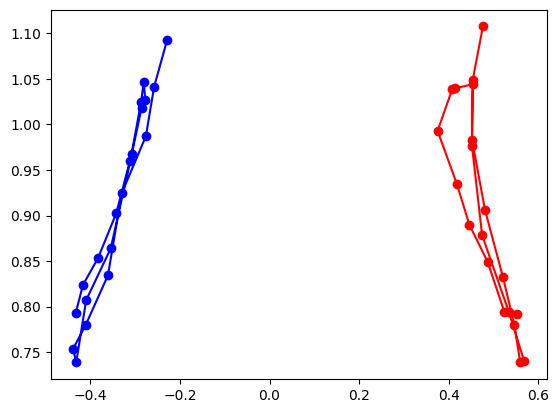

In [27]:
# similar to standardize2, but also includes columns 2 and 3, the positions of the non-dominant hand
# at column 4 it stores the number of hands (which is 1 or 2)
def standardize3(info, fixed_size):
  result = np.zeros((fixed_size, 5))

  centers = get_centers(info.dom)
  resize = interpolate(centers, fixed_size)
  result[:,0:2] = resize

  if (info.nhands == 2):
    centers = get_centers(info.ndom)
    resize = interpolate(centers, fixed_size)
    result[:,2:4] = resize
    result[:,4] = 2
  else:
    result[:,4] = 1

  face = info.face.astype(float)
  left = face[0,0]
  top = face[0,1]
  width = face[0,2]
  height = face[0,3]

  right = left + width - 1
  bottom = top + height - 1
  center_x = (left + right)/2
  center_y = (top + bottom)/2

  result[:,0] = result[:,0] - center_x
  result[:,1] = result[:,1] - center_y

  if (info.nhands == 2):
    result[:,2] = result[:,2] - center_x
    result[:,3] = result[:,3] - center_y

  diag = np.sqrt(width**2 + height**2)
  result[:,0:4] = result[:,0:4] / diag

  return result

info = sign_data(35, lb_ann, lb_hf)
resize = standardize3(info, 20)

print(resize, resize.shape)
plt.plot(resize[:,0], resize[:,1], 'b-o')
plt.plot(resize[:,2], resize[:,3], 'r-o')


In [28]:
# similar to make_set, uses standardize3
def make_set3(annotation, handface, fixed_size):
  number = annotation["id"].shape[0]
  inputs = np.zeros((number, fixed_size, 5))
  labels = np.zeros(number)

  for i in range(0, number):
    info = sign_data(i, annotation, handface)
    matrix = standardize3(info, fixed_size)
    inputs[i] = matrix
    labels[i] = info.label

  return (inputs, labels)

fixed_size = 20

(training_inputs, training_labels) = make_set3(lb_ann, lb_hf, fixed_size)
print(training_inputs.shape)

(test_inputs, test_labels) = make_set3(tb_ann, tb_hf, fixed_size)
print(test_inputs.shape)




(1113, 20, 5)
(1113, 20, 5)


In [29]:
# compute_dist version that works with standardize3
def compute_dist3(test_inputs, test_labels, training_inputs, training_labels):
  test_number = test_inputs.shape[0]
  training_number = training_inputs.shape[0]

  distances = np.zeros((test_number, training_number))

  for j in range(0, test_number):
    for i in range(0, training_number):
      if (test_inputs[j,0,4] != training_inputs[i,0,4]):
        distances[j, i] = np.inf
      else:
        example = training_inputs[i,:,0:4]
        diff = test_inputs[j,:,0:4] - example
        abs_diff = np.abs(diff)
        distances[j, i] = abs_diff.sum()

  return distances

distances = compute_dist3(test_inputs, test_labels, training_inputs, training_labels)

print(distances.shape)

sorted_distances = sort_distances(distances)

(1113, 1113)


In [30]:
accuracy = topk_accuracy(distances, sorted_distances, test_labels, training_labels, 1)
print("Accuracy =", accuracy)

Accuracy = 14.465408805031446


In [31]:
# loads the third part of data-set, so that we have 2 training examples per class
ann_filename = directory + "annotation_gb1113.mat"
hf_filename = directory + "handface_manual_gb1113.mat"

(gb_ann, ann_keys) = load_annotations(ann_filename)
gb_hf = load_handface(hf_filename)

(training_inputs2, training_labels2) = make_set3(gb_ann, gb_hf, fixed_size)
print(training_inputs2.shape)

(training_inputs1, training_labels1) = make_set3(lb_ann, lb_hf, fixed_size)

training_inputs = np.concatenate((training_inputs1, training_inputs2), 0)
training_labels = np.concatenate((training_labels1, training_labels2), 0)
print(training_inputs.shape)

(1113, 20, 5)
(2226, 20, 5)


In [32]:
training_inputs.shape

(2226, 20, 5)

In [33]:
# compute_dist version that works with standardize3
def compute_dist3(test_inputs, test_labels, training_inputs, training_labels):
  test_number = test_inputs.shape[0]
  training_number = training_inputs.shape[0]

  distances = np.zeros((test_number, training_number))

  for j in range(0, test_number):
    for i in range(0, training_number):
      if (test_inputs[j,0,4] != training_inputs[i,0,4]):
        distances[j, i] = np.inf
      else:
        example = training_inputs[i,:,0:4]
        diff = test_inputs[j,:,0:4] - example
        abs_diff = np.abs(diff)
        distances[j, i] = abs_diff.sum()

  return distances

distances = compute_dist3(test_inputs, test_labels, training_inputs, training_labels)

print(distances.shape)

sorted_distances = sort_distances(distances)

(1113, 2226)


In [34]:
accuracy = topk_accuracy(distances, sorted_distances, test_labels, training_labels, 1)
print("Accuracy =", accuracy)

Accuracy = 16.801437556154536
